## Import Required Libraries

In [104]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn import metrics
from scipy.stats import kstest
import matplotlib.pyplot as plt

### Read data

In [105]:
data=pd.read_csv(r'D:\TCS Internship\Project\Sample Data\Final_data.csv',index_col= 0,low_memory=False)

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [82]:
#Check the data columns
data.columns

Index(['Credit_score', 'First_pay_dt', 'First_time_HB_Flag', 'Maturity_dt',
       'MSA', 'Mortgage_Ins%', 'No_of_units', 'Occupancy_status', 'Orig_CLTV',
       'Orig_DTI_ratio', 'Orig_UPB', 'Orig_LTV', 'Orig_Interest_rate',
       'Channel', 'PPM_flag', 'Prod_type', 'Property_state', 'Property_type',
       'Postal_code', 'Loan_seq_no', 'loan_purpose', 'Orig_loan_term',
       'No_of_borrowers', 'Seller_name', 'Service_name', 'Super_conf_flag',
       'Pre_harp_loan_seq_no', 'Prog_indicator', 'Harp_indicator',
       'Prop_val_method', 'Interest_only_Indicator', 'filename',
       'Monthly_report_period', 'Curr_act_UPB', 'Curr_loan_delinq_status',
       'Loan_age', 'Remain_month_legal_maturity', 'Repurchase_flag',
       'Modify_flag', 'Zero_bal_code', 'Zero_bal_effective_dt',
       'Curr_interest_rate', 'Curr_def_UPB', 'Due_dt_of_LPI', 'MI_recov',
       'Net_sales_proceeds', 'Non_MI_recov', 'Expenses', 'Legal_costs',
       'Maintenance_preserv_costs', 'Tax_&_Ins', 'Misc_Exp', 'A

### Calculate WOE and IV

In [83]:
def iv_woe(data, target, bins=10, show_woe=False):

#Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

    #Show WOE Table
    #if show_woe == True:
    #print(d)
    return newDF, woeDF

In [84]:
iv, woe = iv_woe(data = data, target = 'Default', bins=10, show_woe = True) 
print(iv)

Information value of Credit_score is 0.472086
Information value of First_pay_dt is 0.356814
Information value of First_time_HB_Flag is 0.033953
Information value of Maturity_dt is 0.525389
Information value of MSA is 0.013161
Information value of Mortgage_Ins% is 0.083832
Information value of No_of_units is 0.011922
Information value of Occupancy_status is 0.015247
Information value of Orig_CLTV is 0.125916
Information value of Orig_DTI_ratio is 0.31284
Information value of Orig_UPB is 0.059515
Information value of Orig_LTV is 0.117433
Information value of Orig_Interest_rate is 0.383571
Information value of Channel is 0.014421
Information value of PPM_flag is 0.0
Information value of Prod_type is 0.0
Information value of Property_state is 0.149399
Information value of Property_type is 0.001918
Information value of Postal_code is 0.045486
Information value of Loan_seq_no is 7.736075
Information value of loan_purpose is 0.039895
Information value of Orig_loan_term is 0.086059
Information

In [85]:
#IV values condition
conds = [
    iv['IV'] < 0.02, 
    (iv['IV'] >= 0.02) & (iv['IV']<0.1), 
    (iv['IV'] >= 0.01) & (iv['IV']<0.3),
    (iv['IV'] >= 0.03) & (iv['IV']<0.5),     
    iv['IV']>0.5,
]
#List for IV prediction power
choices = [
    'Not useful for prediction',
    'Weak predictive Power',
    'Medium predictive Power',
    'Strong predictive Power',
    'Suspicious Predictive Power',
]
iv['Predictive_Power'] = np.select(conds, choices)

In [86]:
iv

,Variable,IV,Predictive_Power
0,Credit_score,0.472086,Strong predictive Power
0,First_pay_dt,0.356814,Strong predictive Power
0,First_time_HB_Flag,0.033953,Weak predictive Power
0,Maturity_dt,0.525389,Suspicious Predictive Power
0,MSA,0.013161,Not useful for prediction
...,...,...,...
0,UNRATE_Change_MOM,0.659891,Suspicious Predictive Power
0,UNRATE_RelChange_MOM,0.611309,Suspicious Predictive Power
0,CSUSHPISA,2.187071,Suspicious Predictive Power
0,HPI_Change_MOM,1.848170,Suspicious Predictive Power


In [9]:
#Export IV
iv.to_csv("D:\TCS Internship\Project\Sample Data\Final_Predictive_Results.csv")

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3080011 entries, 0 to 3080010
Data columns (total 72 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   Credit_score                     int64  
 1   First_pay_dt                     object 
 2   First_time_HB_Flag               object 
 3   Maturity_dt                      object 
 4   MSA                              float64
 5   Mortgage_Ins%                    int64  
 6   No_of_units                      int64  
 7   Occupancy_status                 object 
 8   Orig_CLTV                        int64  
 9   Orig_DTI_ratio                   int64  
 10  Orig_UPB                         int64  
 11  Orig_LTV                         int64  
 12  Orig_Interest_rate               float64
 13  Channel                          object 
 14  PPM_flag                         object 
 15  Prod_type                        object 
 16  Property_state                   object 
 17  Property

### Handling Missing Values 

In [88]:
#Final Variables
l=['Credit_score','Orig_DTI_ratio','Orig_LTV','Orig_Interest_rate','Property_state','Orig_loan_term','Loan_age','Curr_interest_rate','UNRATE','UNRATE_RelChange_MOM','CSUSHPISA','HPI_RelChange_MOM']
for i in l:
    print(i,"---->","Missing Rows :",len(data[i])-data[i].count(),"| Percentage :",(len(data[i])-data[i].count())/len(data)*100)
    

Credit_score ----> Missing Rows : 0 | Percentage : 0.0
Orig_DTI_ratio ----> Missing Rows : 0 | Percentage : 0.0
Orig_LTV ----> Missing Rows : 0 | Percentage : 0.0
Orig_Interest_rate ----> Missing Rows : 0 | Percentage : 0.0
Property_state ----> Missing Rows : 0 | Percentage : 0.0
Orig_loan_term ----> Missing Rows : 0 | Percentage : 0.0
Loan_age ----> Missing Rows : 0 | Percentage : 0.0
Curr_interest_rate ----> Missing Rows : 0 | Percentage : 0.0
UNRATE ----> Missing Rows : 0 | Percentage : 0.0
UNRATE_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0
CSUSHPISA ----> Missing Rows : 0 | Percentage : 0.0
HPI_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0


In [89]:
#Apply LabelEncoder for Obj datatype
labelencoder=LabelEncoder()
data['Property_state_N'] = labelencoder.fit_transform(data['Property_state'])

In [90]:
#Create new dataframe with Final Variables
df=data[['Credit_score','Orig_DTI_ratio','Orig_LTV','Property_state_N','Curr_interest_rate','UNRATE','HPI_RelChange_MOM','CSUSHPISA','UNRATE_RelChange_MOM','Default','Loan_seq_no','Loan_age','Orig_loan_term']]

In [6]:
df.to_csv("D:\TCS Internship\Project\Sample Data\Final_Variable.csv")

In [91]:
df.columns

Index(['Credit_score', 'Orig_DTI_ratio', 'Orig_LTV', 'Property_state_N',
       'Curr_interest_rate', 'UNRATE', 'HPI_RelChange_MOM', 'CSUSHPISA',
       'UNRATE_RelChange_MOM', 'Default', 'Loan_seq_no', 'Loan_age',
       'Orig_loan_term'],
      dtype='object')

In [92]:
#Split the data for training and testing
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['Loan_seq_no'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]

In [93]:
print(train.shape)
print(test.shape)

(2462644, 13)
(617367, 13)


### Calculate Missing value percentage for Train and Test Dataset

In [94]:
for i in train.columns:
    print(i,"---->","Missing Rows :",len(data[i])-data[i].count(),"| Percentage :",(len(data[i])-data[i].count())/len(data)*100)
    

Credit_score ----> Missing Rows : 0 | Percentage : 0.0
Orig_DTI_ratio ----> Missing Rows : 0 | Percentage : 0.0
Orig_LTV ----> Missing Rows : 0 | Percentage : 0.0
Property_state_N ----> Missing Rows : 0 | Percentage : 0.0
Curr_interest_rate ----> Missing Rows : 0 | Percentage : 0.0
UNRATE ----> Missing Rows : 0 | Percentage : 0.0
HPI_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0
CSUSHPISA ----> Missing Rows : 0 | Percentage : 0.0
UNRATE_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0
Default ----> Missing Rows : 0 | Percentage : 0.0
Loan_seq_no ----> Missing Rows : 0 | Percentage : 0.0
Loan_age ----> Missing Rows : 0 | Percentage : 0.0
Orig_loan_term ----> Missing Rows : 0 | Percentage : 0.0


In [95]:
for i in test.columns:
    print(i,"---->","Missing Rows :",len(data[i])-data[i].count(),"| Percentage :",(len(data[i])-data[i].count())/len(data)*100)

Credit_score ----> Missing Rows : 0 | Percentage : 0.0
Orig_DTI_ratio ----> Missing Rows : 0 | Percentage : 0.0
Orig_LTV ----> Missing Rows : 0 | Percentage : 0.0
Property_state_N ----> Missing Rows : 0 | Percentage : 0.0
Curr_interest_rate ----> Missing Rows : 0 | Percentage : 0.0
UNRATE ----> Missing Rows : 0 | Percentage : 0.0
HPI_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0
CSUSHPISA ----> Missing Rows : 0 | Percentage : 0.0
UNRATE_RelChange_MOM ----> Missing Rows : 0 | Percentage : 0.0
Default ----> Missing Rows : 0 | Percentage : 0.0
Loan_seq_no ----> Missing Rows : 0 | Percentage : 0.0
Loan_age ----> Missing Rows : 0 | Percentage : 0.0
Orig_loan_term ----> Missing Rows : 0 | Percentage : 0.0


In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2462644 entries, 0 to 3080010
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Credit_score          int64  
 1   Orig_DTI_ratio        int64  
 2   Orig_LTV              int64  
 3   Property_state_N      int32  
 4   Curr_interest_rate    float64
 5   UNRATE                float64
 6   HPI_RelChange_MOM     float64
 7   CSUSHPISA             float64
 8   UNRATE_RelChange_MOM  float64
 9   Default               int64  
 10  Loan_seq_no           object 
 11  Loan_age              float64
 12  Orig_loan_term        int64  
dtypes: float64(6), int32(1), int64(5), object(1)
memory usage: 253.6+ MB


In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617367 entries, 167 to 3080008
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Credit_score          617367 non-null  int64  
 1   Orig_DTI_ratio        617367 non-null  int64  
 2   Orig_LTV              617367 non-null  int64  
 3   Property_state_N      617367 non-null  int32  
 4   Curr_interest_rate    617367 non-null  float64
 5   UNRATE                617367 non-null  float64
 6   HPI_RelChange_MOM     617367 non-null  float64
 7   CSUSHPISA             617367 non-null  float64
 8   UNRATE_RelChange_MOM  617367 non-null  float64
 9   Default               617367 non-null  int64  
 10  Loan_seq_no           617367 non-null  object 
 11  Loan_age              617367 non-null  float64
 12  Orig_loan_term        617367 non-null  int64  
dtypes: float64(6), int32(1), int64(5), object(1)
memory usage: 63.6+ MB


In [98]:
#Filter the Final variables for better results 

ytrain=train['Default']
t=data['Loan_age']
Xtrain=train[['Credit_score'
              #,'Orig_DTI_ratio'
              ,'Orig_LTV'
              #,'Property_state_N'
              ,'Curr_interest_rate'
              ,'UNRATE'
              #,'UNRATE_RelChange_MOM'
              ,'CSUSHPISA'
              #,'HPI_RelChange_MOM'
              ,'Orig_loan_term']]

In [99]:
#Filter the Final variables for better results

ytest=test['Default']
Xtest=test[['Credit_score'
              #,'Orig_DTI_ratio'
              ,'Orig_LTV'
              #,'Property_state_N'
              ,'Curr_interest_rate'
              ,'UNRATE'
              #,'UNRATE_RelChange_MOM'
              ,'CSUSHPISA'
              #,'HPI_RelChange_MOM'
              ,'Orig_loan_term']]


### Model Fitting

In [101]:
X=sm.add_constant(Xtrain)
model=sm.Logit(ytrain,Xtrain)
result=model.fit()
result.summary()

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.036257
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:              2462644
Model:                          Logit   Df Residuals:                  2462638
Method:                           MLE   Df Model:                            5
Date:                Sat, 26 Mar 2022   Pseudo R-squ.:                  0.1152
Time:                        11:34:35   Log-Likelihood:                -89287.
converged:                       True   LL-Null:                   -1.0091e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Credit_score          -0.0210      0.000   -181.694      0.000      -0.021      -0.021
Orig_LTV               0.0111      0.001     22.176      0.000       0.010       0.012
Curr_interest_rate     0.2287      0.009     25.411      0.000       0.211       0.246
UNRATE                 0.0206      0.003      6.535      0.000       0.014       0.027
CSUSHPISA              0.0339      0.000    115.372      0.000       0.033       0.034
Orig_loan_term         0.0014      0.000      9.885      0.000       0.001       0.002
======================================================================================
"""

In [102]:
#Accuracy for Train dataset
predict_values = result.predict(Xtrain)
print(roc_auc_score(ytrain,predict_values))

0.8148758298451345


In [103]:
#Accuracy for Test dataset
predict_values = result.predict(Xtest)
#print(predict_values,ytest)
print(roc_auc_score(ytest,predict_values))

0.8161505917506171


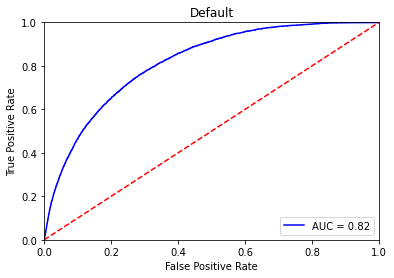

In [109]:
#AUC Curve

fpr, tpr, threshold = metrics.roc_curve(ytest, predict_values)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Default')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Model Validation

In [61]:
predict_values = result.predict(Xtest)
#print(predict_values,ytest)
#print(roc_auc_score(ytest,predict_values))
train_dict= {'time':t,'actuals':ytest,'predicted':predict_values}
train_calc = pd.DataFrame(train_dict)
train_calc.tail(10)

,time,actuals,predicted
3080001,9.0,0.0,0.003280
3080002,10.0,0.0,0.003597
3080003,7.0,NaN,NaN
3080004,8.0,NaN,NaN
3080005,9.0,NaN,NaN
3080006,10.0,NaN,NaN
3080007,9.0,0.0,0.002276
3080008,10.0,0.0,0.002496
3080009,7.0,NaN,NaN
3080010,8.0,NaN,NaN


In [62]:
train_dict = {'actuals':ytest,'predicted':predict_values}
train_calc = pd.DataFrame(train_dict)
train_calc['1-predicted'] = 1-train_calc['predicted']
train_calc['bucket'] = pd.qcut(train_calc['1-predicted'],10,labels=['b1','b2','b3','b4','b5','b6','b7','b8','b9','b10'])

In [66]:
kstable = train_calc.groupby('bucket',as_index = False)[['1-predicted','predicted']].sum()
kstable['event_rate'] = (kstable['predicted'] / kstable['predicted'].sum()).cumsum()
kstable['non_event_rate'] = (kstable['1-predicted'] / kstable['1-predicted'].sum()).cumsum()
kstable['KS'] = (kstable['event_rate'] - kstable['non_event_rate']).abs()

#Prints KS value
print(np.round(kstable['KS'].max(),1))


0.5


In [64]:
#Print KS Table
kstable

,bucket,1-predicted,predicted,event_rate,non_event_rate,KS
0,b1,59482.812579,2254.187421,0.505187,0.097051,0.408136
1,b2,60973.615333,763.384667,0.676269,0.196534,0.479736
2,b3,61275.431145,460.568855,0.779488,0.296509,0.482979
3,b4,61424.993498,312.006502,0.849412,0.396729,0.452683
4,b5,61516.832039,220.167961,0.898754,0.497098,0.401656
5,b6,61577.397210,158.602790,0.934298,0.597566,0.336732
6,b7,61621.339584,115.660416,0.960219,0.698106,0.262113
7,b8,61652.292563,83.707437,0.978979,0.798696,0.180283
8,b9,61678.159215,58.840785,0.992165,0.899329,0.092837
9,b10,61702.041240,34.958760,1.000000,1.000000,0.000000


In [75]:
#Add extra bin0 to ks_df
ks_df = pd.DataFrame({'x_values' : kstable['bucket']
                     ,'event':kstable['event_rate']
                     ,'non_event':kstable['non_event_rate']
                     })
ks_df
k={'x_values':"b0",'event':0,'non_event':0}
ks_bin0 = pd.DataFrame(k,index=[10])
ks_df = pd.concat([ks_bin0,ks_df])
ks_df

,x_values,event,non_event
10,b0,0.000000,0.000000
0,b1,0.505187,0.097051
1,b2,0.676269,0.196534
2,b3,0.779488,0.296509
3,b4,0.849412,0.396729
4,b5,0.898754,0.497098
5,b6,0.934298,0.597566
6,b7,0.960219,0.698106
7,b8,0.978979,0.798696
8,b9,0.992165,0.899329


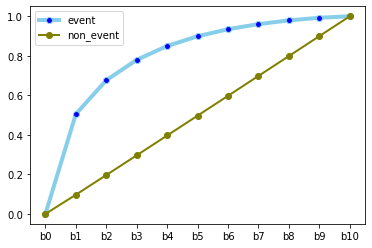

In [106]:
#Visualize KS Test

plt.plot('x_values','event',data=ks_df,marker='o',markerfacecolor='blue',color='skyblue',linewidth=4)
plt.plot('x_values','non_event',data=ks_df,marker='o',markerfacecolor='olive',color='olive',linewidth=2)
plt.legend()
plt.show()